<a href="https://colab.research.google.com/github/sejongsmarcle/2023_Spring_Kaggle_Study/blob/main/%EC%84%9C%EC%9A%B8%EC%8B%9C_%EB%94%B0%EB%A6%89%EC%9D%B4_%EB%8C%80%EC%97%AC%EB%9F%89_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [227]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. import libraries & Data

각 날짜의 1시간 전의 기상상황으로 1시간 후의 따릉이 대여수를 예측하기

In [228]:
# 데이터 처리
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 모델
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor # 랜덤 포레스트

In [229]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/KaggleStudy/DACON 서울시 따릉이 대여량 예측 경진대회/train.csv')
test = pd.read_csv('/content/drive/MyDrive/KaggleStudy/DACON 서울시 따릉이 대여량 예측 경진대회/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/KaggleStudy/DACON 서울시 따릉이 대여량 예측 경진대회/submission.csv')

# 2. 탐색적 자료분석(EDA)

- id: 날짜와 시간별 고유 id   
- hour: 시간       

1시간 전
- temperature: 기온
- precipitation: 비가 오지 않았으면 0, 비가 오면 1
- windspeed: 풍속(평균)
- humidity: 습도
- visibility: 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
- ozone: 오존
- pm10: 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
- pm2.5: 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
- count: 시간에 따른 따릉이 대여 수

In [230]:
train # 모두 수치형 데이터

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
...,...,...,...,...,...,...,...,...,...,...,...
1454,2174,4,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0,21.0
1455,2175,3,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0,20.0
1456,2176,5,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0,22.0
1457,2178,21,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0,216.0


In [231]:
# column 이름이 너무 길어서 짧게 바꿔줌
new_columns = {"hour_bef_temperature":"temperature","hour_bef_precipitation":"precipitation","hour_bef_windspeed":"windspeed","hour_bef_humidity":"humidity","hour_bef_visibility":"visibility","hour_bef_ozone":"ozone","hour_bef_pm10":"pm10","hour_bef_pm2.5":"pm2.5"}

# train, test 셋에 적용
train.rename(columns=new_columns,inplace=True)
test.rename(columns=new_columns,inplace=True)

print(train.head())
print(test.head())

   id  hour  temperature  precipitation  windspeed  humidity  visibility  \
0   3    20         16.3            1.0        1.5      89.0       576.0   
1   6    13         20.1            0.0        1.4      48.0       916.0   
2   7     6         13.9            0.0        0.7      79.0      1382.0   
3   8    23          8.1            0.0        2.7      54.0       946.0   
4   9    18         29.5            0.0        4.8       7.0      2000.0   

   ozone  pm10  pm2.5  count  
0  0.027  76.0   33.0   49.0  
1  0.042  73.0   40.0  159.0  
2  0.033  32.0   19.0   26.0  
3  0.040  75.0   64.0   57.0  
4  0.057  27.0   11.0  431.0  
   id  hour  temperature  precipitation  windspeed  humidity  visibility  \
0   0     7         20.7            0.0        1.3      62.0       954.0   
1   1    17         30.0            0.0        5.4      33.0      1590.0   
2   2    13         19.0            1.0        2.1      95.0       193.0   
3   4     6         22.5            0.0        2.5   

In [232]:
submission

,id,count
0,0,NaN
1,1,NaN
2,2,NaN
3,4,NaN
4,5,NaN
...,...,...
710,2148,NaN
711,2149,NaN
712,2165,NaN
713,2166,NaN


In [233]:
# 겹치는 id 없는 것 확인
print(train['id'].unique().shape)

(1459,)


In [234]:
print("train: ",train.shape)
print("test: ",test.shape)
print("submission: ",submission.shape)

train:  (1459, 11)
test:  (715, 10)
submission:  (715, 2)


In [235]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1459 non-null   int64  
 1   hour           1459 non-null   int64  
 2   temperature    1457 non-null   float64
 3   precipitation  1457 non-null   float64
 4   windspeed      1450 non-null   float64
 5   humidity       1457 non-null   float64
 6   visibility     1457 non-null   float64
 7   ozone          1383 non-null   float64
 8   pm10           1369 non-null   float64
 9   pm2.5          1342 non-null   float64
 10  count          1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [236]:
train.isnull().sum()
# 결측치 확인

id                 0
hour               0
temperature        2
precipitation      2
windspeed          9
humidity           2
visibility         2
ozone             76
pm10              90
pm2.5            117
count              0
dtype: int64

In [237]:
train.describe()

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


In [238]:
test.describe()

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5
count,715.000000,715.000000,714.000000,714.000000,714.000000,714.000000,714.000000,680.000000,678.000000,679.000000
mean,1056.854545,11.472727,23.263305,0.051821,2.388515,56.668067,1359.494398,0.041196,36.930678,24.939617
std,625.574471,6.928427,4.039645,0.221820,1.171270,19.661880,614.171870,0.020656,12.641503,10.075857
min,0.000000,0.000000,14.600000,0.000000,0.000000,16.000000,126.000000,0.003000,9.000000,7.000000
25%,507.000000,5.500000,20.300000,0.000000,1.500000,42.000000,807.250000,0.027000,28.000000,17.000000
50%,1046.000000,11.000000,22.900000,0.000000,2.300000,55.000000,1489.000000,0.039000,35.000000,24.000000
75%,1616.500000,17.000000,26.375000,0.000000,3.275000,73.750000,2000.000000,0.052250,45.000000,31.000000
max,2177.000000,23.000000,33.800000,1.000000,5.900000,100.000000,2000.000000,0.138000,94.000000,69.000000


## feature에 따른 통계량 확인
* pd.DataFrame.groupby()
* 시간에 따른 통계량 확인

<Axes: xlabel='hour'>

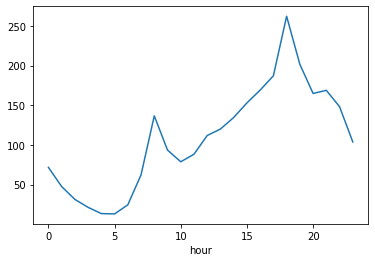

In [239]:
# 시간으로 묶음
train.groupby('hour').mean()['count'].plot()
# 시간 별 평균 출력

출퇴근 시에 대여량이 늘어난다는 것을 알 수 있음

### plt.plot 커스터마이징

Text(0, 0.5, 'count')

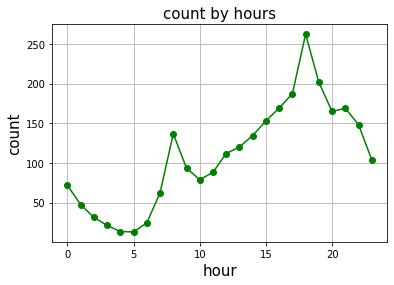

In [240]:
plt.plot(train.groupby('hour').mean()['count'],'go-')
plt.grid()

plt.title('count by hours', fontsize=15)
plt.xlabel('hour', fontsize=15)
plt.ylabel('count', fontsize=15)

## 상관계수
변수 간의 관계를 수치로 한 번에 알려줌


<Axes: >

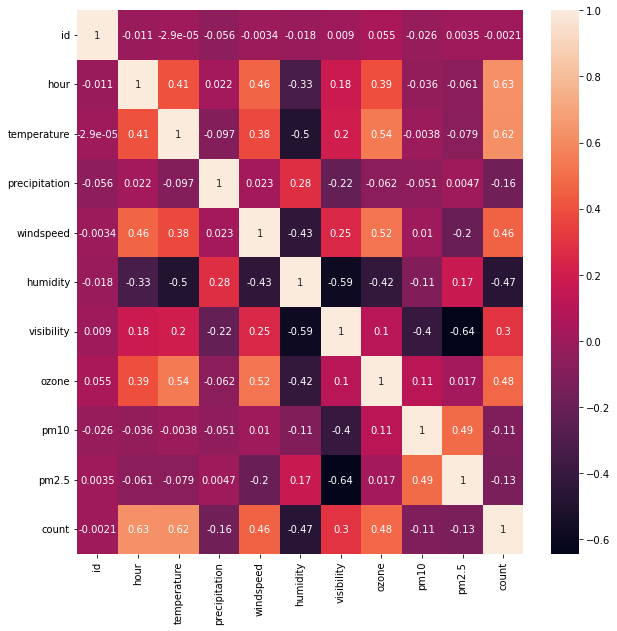

In [241]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), annot=True)
# annot=True로 해야 숫자 나옴

### 사용할 변수들
상관계수 높은 변수들만 사용
* *hour(0.63)*
* *temperature(0.62)*
* ozone(0.48) -> 추가
* huminity(0.47) -> 추가
* *windspeed(0.46)*

# 3. 데이터 전처리
## 결측치 대체

In [242]:
train.isna().sum()
# 결측치가 항목별로 꽤 있음. 모델의 학습을 위해 없애줘야 함.

id                 0
hour               0
temperature        2
precipitation      2
windspeed          9
humidity           2
visibility         2
ozone             76
pm10              90
pm2.5            117
count              0
dtype: int64

### 1) temperature 항목

In [243]:
train[train['temperature'].isna()]
# temperature의 결측치 인덱싱 해 결측치 확인

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
934,1420,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


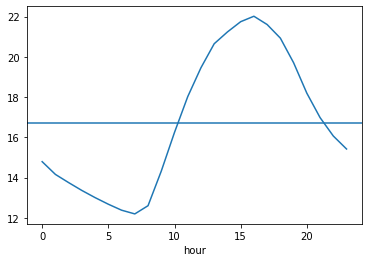

In [244]:
# hour에 따라 temperature group화 해 평균 plot

train.groupby('hour')['temperature'].mean().plot()
plt.axhline(train.groupby('hour')['temperature'].mean().mean()) # 전체 온도 평균
# 온도는 낮, 밤에 따라 차이가 큼 -> 중앙값(평균) 쓰기 어려움
# 따라서 시간 별 평균 온도로 결측값 대체

In [245]:
train.groupby('hour')['temperature'].mean()

hour
0     14.788136
1     14.155738
2     13.747541
3     13.357377
4     13.001639
5     12.673770
6     12.377049
7     12.191803
8     12.600000
9     14.318033
10    16.242623
11    18.019672
12    19.457377
13    20.648333
14    21.234426
15    21.744262
16    22.015000
17    21.603333
18    20.926667
19    19.704918
20    18.191803
21    16.978333
22    16.063934
23    15.418033
Name: temperature, dtype: float64

In [246]:
# fillna를 이용해 dictionary 형태로 넣어줌
train['temperature'].fillna({934:14.788136,1035:20.926667}, inplace=True)

In [247]:
train.loc[[934,1035],:]

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
934,1420,0,14.788136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,20.926667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


### 2) windspeed 항목

In [248]:
train[train['windspeed'].isna()]

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
18,33,13,22.600000,0.0,NaN,41.0,987.0,0.046,64.0,39.0,208.0
244,381,1,14.100000,0.0,NaN,55.0,1992.0,NaN,NaN,NaN,38.0
260,404,3,14.000000,0.0,NaN,50.0,2000.0,0.049,35.0,22.0,17.0
376,570,0,14.300000,0.0,NaN,49.0,2000.0,0.044,37.0,20.0,58.0
780,1196,20,16.500000,0.0,NaN,31.0,2000.0,0.058,39.0,18.0,181.0
934,1420,0,14.788136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,20.926667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1138,1717,12,21.400000,0.0,NaN,44.0,1375.0,0.044,61.0,37.0,116.0
1229,1855,2,14.000000,0.0,NaN,52.0,2000.0,0.044,37.0,20.0,20.0


<Axes: xlabel='hour'>

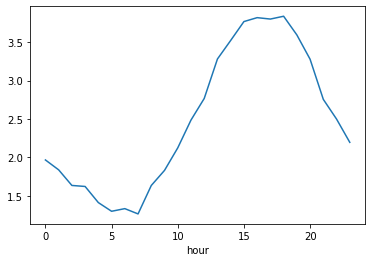

In [249]:
train.groupby('hour')['windspeed'].mean().plot()
# 시간에 따라 다른 경향

In [250]:
train[train['windspeed'].isna()].index

Int64Index([18, 244, 260, 376, 780, 934, 1035, 1138, 1229], dtype='int64')

In [251]:
train.groupby('hour')['windspeed'].mean()

hour
0     1.965517
1     1.836667
2     1.633333
3     1.620000
4     1.409836
5     1.296721
6     1.331148
7     1.262295
8     1.632787
9     1.829508
10    2.122951
11    2.485246
12    2.766667
13    3.281356
14    3.522951
15    3.768852
16    3.820000
17    3.801667
18    3.838333
19    3.595082
20    3.278333
21    2.755000
22    2.498361
23    2.195082
Name: windspeed, dtype: float64

In [252]:
# fillna를 이용해 dictionary 형태로 넣어줌
train['windspeed'].fillna({18:3.281356, 244:1.836667, 260:1.620000, 376:1.965517, 780:3.278333, 934:1.965517, 1035:3.838333, 1138:2.766667, 1229:1.633333}, inplace=True)

In [253]:
train.loc[[18, 244, 260, 376, 780, 934, 1035, 1138, 1229],:]

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
18,33,13,22.600000,0.0,3.281356,41.0,987.0,0.046,64.0,39.0,208.0
244,381,1,14.100000,0.0,1.836667,55.0,1992.0,NaN,NaN,NaN,38.0
260,404,3,14.000000,0.0,1.620000,50.0,2000.0,0.049,35.0,22.0,17.0
376,570,0,14.300000,0.0,1.965517,49.0,2000.0,0.044,37.0,20.0,58.0
780,1196,20,16.500000,0.0,3.278333,31.0,2000.0,0.058,39.0,18.0,181.0
934,1420,0,14.788136,NaN,1.965517,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,20.926667,NaN,3.838333,NaN,NaN,NaN,NaN,NaN,1.0
1138,1717,12,21.400000,0.0,2.766667,44.0,1375.0,0.044,61.0,37.0,116.0
1229,1855,2,14.000000,0.0,1.633333,52.0,2000.0,0.044,37.0,20.0,20.0


test 데이터도 결측치 채워줘야 함

In [254]:
test.isna().sum()

id                0
hour              0
temperature       1
precipitation     1
windspeed         1
humidity          1
visibility        1
ozone            35
pm10             37
pm2.5            36
dtype: int64

In [255]:
test[test['temperature'].isna()]

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5
653,1943,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [256]:
test['temperature'].fillna(19.704918, inplace=True)

In [257]:
test[test['windspeed'].isna()]

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5
653,1943,19,19.704918,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [258]:
test['windspeed'].fillna(3.595082, inplace=True)

In [259]:
test.isna().sum()

id                0
hour              0
temperature       0
precipitation     1
windspeed         0
humidity          1
visibility        1
ozone            35
pm10             37
pm2.5            36
dtype: int64

## 3) ozone 항목


In [260]:
train[train['ozone'].isna()]

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
14,28,1,20.0,0.0,1.8,58.0,2000.0,NaN,NaN,NaN,74.0
44,76,17,21.7,0.0,3.0,35.0,2000.0,NaN,32.0,19.0,213.0
46,78,1,12.2,0.0,3.0,49.0,1071.0,NaN,NaN,NaN,36.0
84,130,1,9.4,0.0,2.5,65.0,1907.0,NaN,NaN,NaN,39.0
122,181,16,26.2,0.0,4.3,31.0,1718.0,NaN,47.0,23.0,136.0
...,...,...,...,...,...,...,...,...,...,...,...
1283,1941,1,16.6,0.0,2.1,35.0,2000.0,NaN,NaN,NaN,62.0
1322,1994,1,15.1,0.0,1.3,35.0,2000.0,NaN,NaN,NaN,40.0
1329,2005,1,17.7,0.0,1.0,43.0,1338.0,NaN,NaN,NaN,69.0
1361,2047,1,12.6,0.0,2.4,48.0,1805.0,NaN,NaN,NaN,43.0


<Axes: xlabel='temperature'>

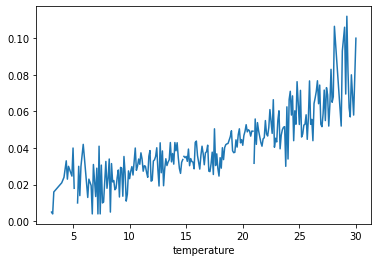

In [261]:
train.groupby('temperature')['ozone'].mean().plot()

<Axes: xlabel='hour'>

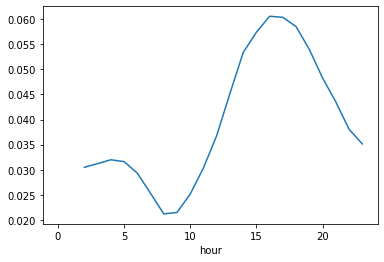

In [262]:
train.groupby('hour')['ozone'].mean().plot()

ozone양은 'temperature'와 'hour'로 그룹화 가능     
- plot을 보았을 때, 'hour'로 그룹화 하는 게 더 적절해보임

In [263]:
train['ozone'].isna().sum()

76

null 값이 총 76개로 수기로 채워넣기에는 무리임    
- if 문으로 자동화 하는 방법 고려

In [264]:
train.groupby('hour')['ozone'].mean()

hour
0     0.033763
1          NaN
2     0.030492
3     0.031213
4     0.031984
5     0.031623
6     0.029317
7     0.025300
8     0.021197
9     0.021492
10    0.025167
11    0.030367
12    0.036817
13    0.045203
14    0.053344
15    0.057400
16    0.060579
17    0.060362
18    0.058508
19    0.053967
20    0.048279
21    0.043517
22    0.038066
23    0.035148
Name: ozone, dtype: float64

In [265]:
train['ozone'].isna().sum()

76

In [266]:
ozone_NaN_idx = train[train['ozone'].isna()].index
print(ozone_NaN_idx)
print(train[train['ozone'].isna()].shape)

Int64Index([  14,   44,   46,   84,  122,  140,  142,  147,  158,  176,  222,
             236,  244,  265,  289,  317,  324,  331,  356,  422,  429,  451,
             463,  466,  472,  479,  507,  532,  537,  554,  576,  579,  589,
             595,  623,  624,  631,  645,  649,  660,  686,  698,  708,  728,
             745,  763,  778,  796,  811,  861,  868,  876,  897,  934,  957,
             970, 1024, 1035, 1070, 1100, 1120, 1142, 1154, 1156, 1165, 1168,
            1186, 1211, 1221, 1273, 1278, 1283, 1322, 1329, 1361, 1391],
           dtype='int64')
(76, 11)


In [267]:
## 'ozone'이 NaN 데이터인 경우, 그 'hour'가 1인 경우
(train[train['ozone'].isna()]['hour']==1).sum()

61

In [268]:
## 'hour'가 1인 경우
train[train['hour']==1].shape

(61, 11)

'hour'가 1일 때 모든 'ozone' 데이터가 NaN임
- 0시와 2시의 평균 오존 수치의 중간 값으로 fillna

In [269]:
hour23_0_ozone = (train[train['hour']==23]['ozone'].mean()+train[train['hour']==0]['ozone'].mean())*0.5
hour2_3_ozone = (train[train['hour']==2]['ozone'].mean()+train[train['hour']==3]['ozone'].mean())*0.5

In [270]:
hour1_ozone = (hour23_0_ozone+hour2_3_ozone)*0.5

결측치 채우기 자동화

In [271]:
train['hour'][:]

0       20
1       13
2        6
3       23
4       18
        ..
1454     4
1455     3
1456     5
1457    21
1458    17
Name: hour, Length: 1459, dtype: int64

In [272]:
mean_ozone_by_hour = train.groupby('hour')['ozone'].mean()
mean_ozone_by_hour[1] = hour1_ozone

In [273]:
mean_ozone_by_hour

hour
0     0.033763
1     0.032654
2     0.030492
3     0.031213
4     0.031984
5     0.031623
6     0.029317
7     0.025300
8     0.021197
9     0.021492
10    0.025167
11    0.030367
12    0.036817
13    0.045203
14    0.053344
15    0.057400
16    0.060579
17    0.060362
18    0.058508
19    0.053967
20    0.048279
21    0.043517
22    0.038066
23    0.035148
Name: ozone, dtype: float64

<Axes: xlabel='hour'>

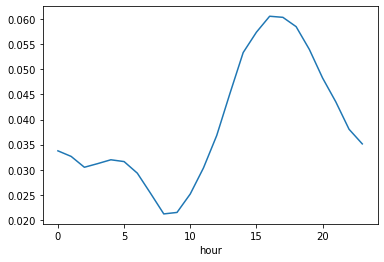

In [274]:
mean_ozone_by_hour.plot()

결측치 채우기

In [275]:
for idx in ozone_NaN_idx:
  idx_hour = train['hour'][idx]
  train['ozone'][idx] = mean_ozone_by_hour[idx_hour]

<ipython-input-275-44e0bd9821e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ozone'][idx] = mean_ozone_by_hour[idx_hour]


In [276]:
train

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
...,...,...,...,...,...,...,...,...,...,...,...
1454,2174,4,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0,21.0
1455,2175,3,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0,20.0
1456,2176,5,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0,22.0
1457,2178,21,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0,216.0


In [277]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1459 non-null   int64  
 1   hour           1459 non-null   int64  
 2   temperature    1459 non-null   float64
 3   precipitation  1457 non-null   float64
 4   windspeed      1459 non-null   float64
 5   humidity       1457 non-null   float64
 6   visibility     1457 non-null   float64
 7   ozone          1459 non-null   float64
 8   pm10           1369 non-null   float64
 9   pm2.5          1342 non-null   float64
 10  count          1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


## 4) humidity 항목
- null 값 두 개 밖에 없음

In [278]:
train[train['humidity'].isna()]

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
934,1420,0,14.788136,NaN,1.965517,NaN,NaN,0.033763,NaN,NaN,39.0
1035,1553,18,20.926667,NaN,3.838333,NaN,NaN,0.058508,NaN,NaN,1.0


<Axes: xlabel='temperature'>

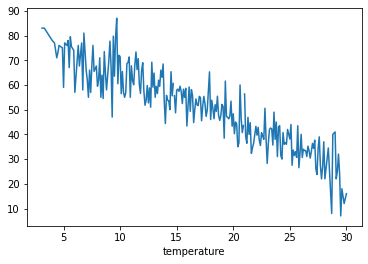

In [279]:
train.groupby('temperature').mean()['humidity'].plot()

<Axes: xlabel='hour'>

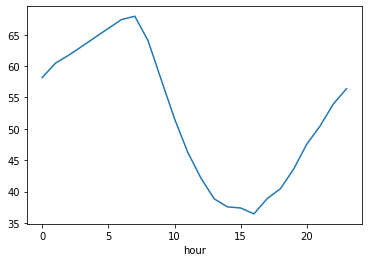

In [280]:
train.groupby('hour').mean()['humidity'].plot()

hour 항목에 따라 group화 하는 게 적절해 보임

In [281]:
train.groupby('hour').mean()['humidity']

hour
0     58.169492
1     60.459016
2     61.721311
3     63.131148
4     64.573770
5     66.000000
6     67.409836
7     67.934426
8     64.049180
9     57.803279
10    51.622951
11    46.262295
12    42.147541
13    38.850000
14    37.573770
15    37.393443
16    36.450000
17    38.883333
18    40.450000
19    43.573770
20    47.573770
21    50.450000
22    53.950820
23    56.393443
Name: humidity, dtype: float64

In [282]:
train['humidity'].fillna({934:58.169492,1035:40.450000}, inplace=True)

In [283]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1459 non-null   int64  
 1   hour           1459 non-null   int64  
 2   temperature    1459 non-null   float64
 3   precipitation  1457 non-null   float64
 4   windspeed      1459 non-null   float64
 5   humidity       1459 non-null   float64
 6   visibility     1457 non-null   float64
 7   ozone          1459 non-null   float64
 8   pm10           1369 non-null   float64
 9   pm2.5          1342 non-null   float64
 10  count          1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


테스트 셋도 마찬가지로 NaN 값 없애줌

In [284]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             715 non-null    int64  
 1   hour           715 non-null    int64  
 2   temperature    715 non-null    float64
 3   precipitation  714 non-null    float64
 4   windspeed      715 non-null    float64
 5   humidity       714 non-null    float64
 6   visibility     714 non-null    float64
 7   ozone          680 non-null    float64
 8   pm10           678 non-null    float64
 9   pm2.5          679 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 56.0 KB


In [285]:
ozone_NaN_idx = test[test['ozone'].isna()].index

for idx in ozone_NaN_idx:
  idx_hour = test['hour'][idx]
  test['ozone'][idx] = mean_ozone_by_hour[idx_hour]

<ipython-input-285-548ce46c73d0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ozone'][idx] = mean_ozone_by_hour[idx_hour]


In [286]:
test[test['ozone'].isna()]

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5


In [287]:
test[test['humidity'].isna()]

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5
653,1943,19,19.704918,NaN,3.595082,NaN,NaN,0.053967,NaN,NaN


In [288]:
test['humidity'].fillna(43.573770, inplace=True)

In [289]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             715 non-null    int64  
 1   hour           715 non-null    int64  
 2   temperature    715 non-null    float64
 3   precipitation  714 non-null    float64
 4   windspeed      715 non-null    float64
 5   humidity       715 non-null    float64
 6   visibility     714 non-null    float64
 7   ozone          715 non-null    float64
 8   pm10           678 non-null    float64
 9   pm2.5          679 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 56.0 KB


# 4. 변수 선택 및 모델 구축

In [290]:
features_1 = ['hour','temperature','windspeed']
features_2 = ['hour','temperature','windspeed','ozone','humidity']

In [291]:
x_train_1 = train[features_1]
y_train_1 = train['count']
x_test_1 = test[features_1]

x_train_2 = train[features_2]
y_train_2 = train['count']
x_test_2 = test[features_2]

In [292]:
print(x_train_1.shape)
print(y_train_1.shape)
print(x_test_1.shape)

(1459, 3)
(1459,)
(715, 3)


### [RandomForestRegressor document](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

In [293]:
model100 = RandomForestRegressor(n_estimators=100, random_state=0)
model100_5 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
model200 = RandomForestRegressor(n_estimators=200, random_state=0)

### feature_1로 학습

In [294]:
model100.fit(x_train_1,y_train_1)
model100_5.fit(x_train_1,y_train_1)
model200.fit(x_train_1,y_train_1)

RandomForestRegressor(n_estimators=200, random_state=0)

In [295]:
y_pred_1_1 = model100.predict(x_test_1)
y_pred_1_2 = model100_5.predict(x_test_1)
y_pred_1_3 = model200.predict(x_test_1)

In [296]:
submission['count'] = y_pred_1_1
submission.to_csv('f1_model100.csv', index=False)

In [297]:
submission['count'] = y_pred_1_2
submission.to_csv('f1_model100_5.csv', index=False)

In [298]:
submission['count'] = y_pred_1_3
submission.to_csv('f1_model200.csv', index=False)

### feature_2로 학습

In [299]:
model100.fit(x_train_2,y_train_2)
model100_5.fit(x_train_2,y_train_2)
model200.fit(x_train_2,y_train_2)

RandomForestRegressor(n_estimators=200, random_state=0)

In [300]:
y_pred_2_1 = model100.predict(x_test_2)
y_pred_2_2 = model100_5.predict(x_test_2)
y_pred_2_3 = model200.predict(x_test_2)

In [302]:
submission['count'] = y_pred_2_1
submission.to_csv('f2_model100.csv', index=False)

submission['count'] = y_pred_2_1
submission.to_csv('f2_model100_5.csv', index=False)

submission['count'] = y_pred_2_1
submission.to_csv('f2_model200.csv', index=False)